In [1]:
import tensorflow as tf 
import pandas as pd 
import numpy as np


2024-12-23 20:17:02.699306: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-23 20:17:02.707593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-23 20:17:02.719344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-23 20:17:02.722755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 20:17:02.731237: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_data = pd.read_csv('US_election_Sentiment_Data/train.csv')
train_data.head(5)

,tweet_id,user_handle,timestamp,tweet_text,candidate,party,retweets,likes,sentiment
0,1,@user123,2024-11-03 08:45:00,Excited to see Kamala Harris leading the Democ...,Kamala Harris,Democratic Party,120,450,positive
1,2,@politicsFan,2024-11-03 09:15:23,Donald Trump's policies are the best for our e...,Donald Trump,Republican Party,85,300,positive
2,3,@greenAdvocate,2024-11-03 10:05:45,Jill Stein's environmental plans are exactly w...,Jill Stein,Green Party,60,200,positive
3,4,@indieVoice,2024-11-03 11:20:10,Robert Kennedy offers a fresh perspective outs...,Robert Kennedy,Independent,40,150,neutral
4,5,@libertyLover,2024-11-03 12:35:55,Chase Oliver's libertarian stance promotes tru...,Chase Oliver,Libertarian Party,30,120,positive


# Data Cleaning

In [3]:
import pandas as pd

# Load data
train_data = pd.read_csv('US_election_Sentiment_Data/train.csv')

# Print number of distinct values in the sentiment column
num_distinct_sentiments = train_data['sentiment'].nunique()
print("Number of distinct sentiment values:", num_distinct_sentiments)

# Print the distinct sentiment values
distinct_sentiments = train_data['sentiment'].unique()
print("Distinct sentiment values:", distinct_sentiments)

Number of distinct sentiment values: 4
Distinct sentiment values: ['positive' 'neutral' 'negative' 'positive  ']


In [23]:
import pandas as pd

# Clean the sentiment column in-memory
train_data['sentiment'] = train_data['sentiment'].str.strip()

# Print number of distinct values in the sentiment column after cleaning
num_distinct_sentiments = train_data['sentiment'].nunique()
print("Number of distinct sentiment values after cleaning:", num_distinct_sentiments)

# Print the distinct sentiment values after cleaning
distinct_sentiments = train_data['sentiment'].unique()
print("Distinct sentiment values after cleaning:", distinct_sentiments)

Number of distinct sentiment values after cleaning: 3
Distinct sentiment values after cleaning: ['positive' 'neutral' 'negative']


#### Cleaning data for val and test

In [4]:
import pandas as pd
# Load data
val_data = pd.read_csv('US_election_Sentiment_Data/train.csv')
# Clean the sentiment column in-memory
val_data['sentiment'] = val_data['sentiment'].str.strip()

# Print number of distinct values in the sentiment column after cleaning
num_distinct_sentiments = val_data['sentiment'].nunique()
print("Number of distinct sentiment values after cleaning:", num_distinct_sentiments)

# Print the distinct sentiment values after cleaning
distinct_sentiments = val_data['sentiment'].unique()
print("Distinct sentiment values after cleaning:", distinct_sentiments)

Number of distinct sentiment values after cleaning: 3
Distinct sentiment values after cleaning: ['positive' 'neutral' 'negative']


In [5]:
import pandas as pd
# Load data
test_data = pd.read_csv('US_election_Sentiment_Data/train.csv')
# Clean the sentiment column in-memory
test_data['sentiment'] = test_data['sentiment'].str.strip()

# Print number of distinct values in the sentiment column after cleaning
num_distinct_sentiments = test_data['sentiment'].nunique()
print("Number of distinct sentiment values after cleaning:", num_distinct_sentiments)

# Print the distinct sentiment values after cleaning
distinct_sentiments = test_data['sentiment'].unique()
print("Distinct sentiment values after cleaning:", distinct_sentiments)

Number of distinct sentiment values after cleaning: 3
Distinct sentiment values after cleaning: ['positive' 'neutral' 'negative']


# Data Analysis

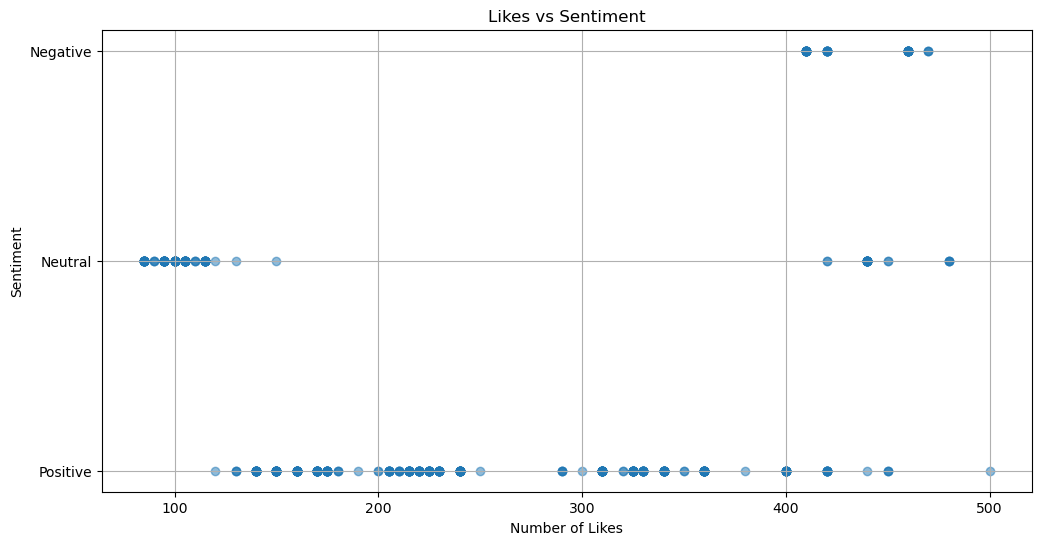

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Encode sentiment
sentiment_mapping = {'positive': 1, 'neutral': 2, 'negative': 3}
train_data['sentiment_encoded'] = train_data['sentiment'].map(sentiment_mapping)

# Plot Likes vs Sentiment
plt.figure(figsize=(12, 6))
plt.scatter(train_data['likes'], train_data['sentiment_encoded'], alpha=0.5)
plt.title('Likes vs Sentiment')
plt.xlabel('Number of Likes')
plt.ylabel('Sentiment')
plt.yticks([1, 2, 3], ['Positive', 'Neutral', 'Negative'])
plt.grid(True)
plt.show()

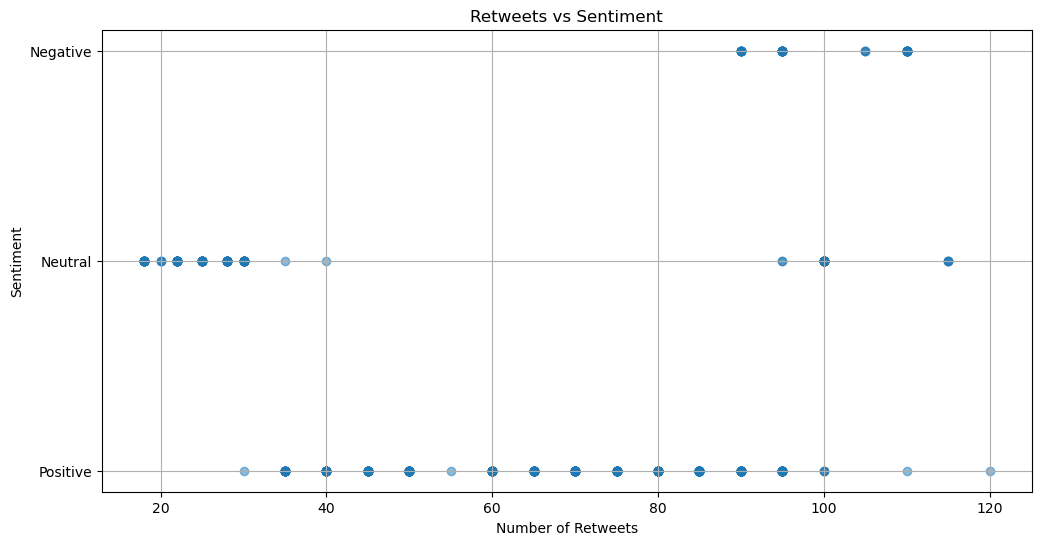

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Encode sentiment
sentiment_mapping = {'positive': 1, 'neutral': 2, 'negative': 3}
train_data['sentiment_encoded'] = train_data['sentiment'].map(sentiment_mapping)

# Plot Retweets vs Sentiment
plt.figure(figsize=(12, 6))
plt.scatter(train_data['retweets'], train_data['sentiment_encoded'], alpha=0.5)
plt.title('Retweets vs Sentiment')
plt.xlabel('Number of Retweets')
plt.ylabel('Sentiment')
plt.yticks([1, 2, 3], ['Positive', 'Neutral', 'Negative'])
plt.grid(True)
plt.show()

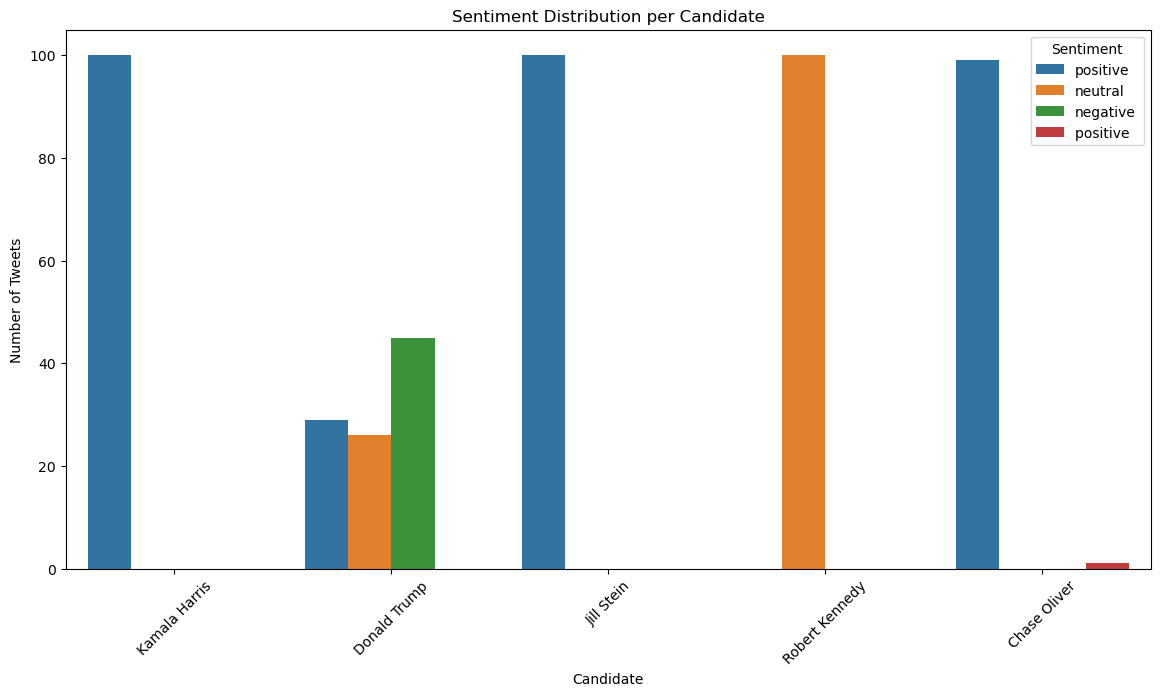

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Candidate vs Sentiment
plt.figure(figsize=(14, 7))
sns.countplot(x='candidate', hue='sentiment', data=train_data)
plt.title('Sentiment Distribution per Candidate')
plt.xlabel('Candidate')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

To make the model not to be biased towards candidates the above data will not be used

# Data preparation

From the above analysis only tweet text,retweets,likes will be used

In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Clean the sentiment column in-memory
train_data['sentiment'] = train_data['sentiment'].str.strip()
val_data['sentiment'] = val_data['sentiment'].str.strip()
test_data['sentiment'] = test_data['sentiment'].str.strip()

# Combine tweet texts for tokenizer fitting
combined_text = pd.concat([train_data['tweet_text'], val_data['tweet_text'], test_data['tweet_text']])

# Initialize tokenizer class
tokenizer = Tokenizer(oov_token="<oov>")

# Generate word index dictionary
tokenizer.fit_on_texts(combined_text)
word_index = tokenizer.word_index

# Generate sequences for each dataset
train_sequences = tokenizer.texts_to_sequences(train_data['tweet_text'])
val_sequences = tokenizer.texts_to_sequences(val_data['tweet_text'])
test_sequences = tokenizer.texts_to_sequences(test_data['tweet_text'])

# Define maximum length for padding
max_length = 50  # Example maximum length

# Pad sequences to ensure uniform length
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
val_padded_sequences = pad_sequences(val_sequences, maxlen=max_length, padding='post')
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Add the padded sequences to the respective DataFrames
train_data['input_sequences'] = list(train_padded_sequences)
val_data['input_sequences'] = list(val_padded_sequences)
test_data['input_sequences'] = list(test_padded_sequences)

# Encode sentiment labels for each dataset
label_encoder = LabelEncoder()
train_integer_encoded = label_encoder.fit_transform(train_data['sentiment'])
val_integer_encoded = label_encoder.transform(val_data['sentiment'])
test_integer_encoded = label_encoder.transform(test_data['sentiment'])

# One-hot encode the integer encoded labels
onehot_encoder = OneHotEncoder(sparse_output=False)
train_integer_encoded = train_integer_encoded.reshape(len(train_integer_encoded), 1)
val_integer_encoded = val_integer_encoded.reshape(len(val_integer_encoded), 1)
test_integer_encoded = test_integer_encoded.reshape(len(test_integer_encoded), 1)

train_onehot_encoded = onehot_encoder.fit_transform(train_integer_encoded)
val_onehot_encoded = onehot_encoder.transform(val_integer_encoded)
test_onehot_encoded = onehot_encoder.transform(test_integer_encoded)

# Add one-hot encoded vectors as a single column to the DataFrames
train_data['sentiment_label'] = list(train_onehot_encoded)
val_data['sentiment_label'] = list(val_onehot_encoded)
test_data['sentiment_label'] = list(test_onehot_encoded)

# Display the first few rows to verify
print(train_data[['tweet_text', 'input_sequences', 'sentiment', 'sentiment_label']].head())
print(val_data[['tweet_text', 'input_sequences', 'sentiment', 'sentiment_label']].head())
print(test_data[['tweet_text', 'input_sequences', 'sentiment', 'sentiment_label']].head())

                                          tweet_text  \
0  Excited to see Kamala Harris leading the Democ...   
1  Donald Trump's policies are the best for our e...   
2  Jill Stein's environmental plans are exactly w...   
3  Robert Kennedy offers a fresh perspective outs...   
4  Chase Oliver's libertarian stance promotes tru...   

                                     input_sequences sentiment  \
0  [335, 4, 336, 5, 15, 43, 11, 337, 210, 0, 0, 0...  positive   
1  [275, 6, 12, 3, 11, 338, 10, 276, 277, 0, 0, 0...  positive   
2  [7, 16, 189, 41, 3, 339, 340, 341, 190, 0, 0, ...  positive   
3  [8, 14, 66, 13, 234, 211, 75, 11, 342, 92, 343...   neutral   
4  [9, 20, 82, 30, 83, 344, 159, 0, 0, 0, 0, 0, 0...  positive   

   sentiment_label  
0  [0.0, 0.0, 1.0]  
1  [0.0, 0.0, 1.0]  
2  [0.0, 0.0, 1.0]  
3  [0.0, 1.0, 0.0]  
4  [0.0, 0.0, 1.0]  
                                          tweet_text  \
0  Excited to see Kamala Harris leading the Democ...   
1  Donald Trump's policies a

### Preparing Validation and test data

In [10]:

# Convert input data and labels to NumPy arrays
train_input = np.array(train_padded_sequences)
val_input = np.array(val_padded_sequences)
test_input = np.array(test_padded_sequences)

train_label = np.array(train_onehot_encoded)
val_label = np.array(val_onehot_encoded)
test_label = np.array(test_onehot_encoded)


# Creating a model

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


# Define the model
vocab_size = len(word_index) + 1  # Vocabulary size
embedding_dim = 100  # Embedding dimensions
lstm_units = 128  # Number of LSTM units

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(units=lstm_units, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=lstm_units),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=3, activation='softmax')  # Output layer with 3 nodes for 3 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/lib/python3/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1734985236.082013   85213 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734985236.113999   85213 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734985236.114081   85213 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734985236.118110   85213 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734985236.118206   85213 cuda_executor.c

In [16]:
# Train the model
history = model.fit(train_input, train_label, epochs=64, batch_size=32, validation_data=(val_input, val_label))

Epoch 1/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8507 - loss: 0.3676 - val_accuracy: 0.8520 - val_loss: 0.3635
Epoch 2/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8416 - loss: 0.3851 - val_accuracy: 0.8520 - val_loss: 0.3634
Epoch 3/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8562 - loss: 0.3609 - val_accuracy: 0.8520 - val_loss: 0.3635
Epoch 4/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8694 - loss: 0.3430 - val_accuracy: 0.8520 - val_loss: 0.3628
Epoch 5/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8569 - loss: 0.3433 - val_accuracy: 0.8520 - val_loss: 0.3630
Epoch 6/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8355 - loss: 0.3744 - val_accuracy: 0.8520 - val_loss: 0.3627
Epoch 7/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8473 - loss: 0.3719 - val_accuracy: 0.8520 - val_loss: 0.3629
Epoch 8/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8453 - loss: 0.3815 - val_accuracy: 0.8520 - v

In [17]:

# Evaluate the model
loss, accuracy = model.evaluate(test_input, test_label)
print(f'Test Accuracy: {accuracy:.4f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8484 - loss: 0.3689
Test Accuracy: 0.8520


### Using additional data of retweets and likes

In [18]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Normalize retweets and likes
scaler = StandardScaler()
train_additional_features = scaler.fit_transform(train_data[['retweets', 'likes']])
val_additional_features = scaler.transform(val_data[['retweets', 'likes']])
test_additional_features = scaler.transform(test_data[['retweets', 'likes']])


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate

# Define the model
vocab_size = len(word_index) + 1  # Vocabulary size
embedding_dim = 100  # Embedding dimensions
lstm_units = 128  # Number of LSTM units

# Text input
text_input = Input(shape=(max_length,), name='text_input')
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(text_input)
lstm_out = LSTM(units=lstm_units, return_sequences=True)(embedding)
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = LSTM(units=lstm_units)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)

# Additional features input
additional_input = Input(shape=(2,), name='additional_input')

# Concatenate LSTM output with additional features
concat = Concatenate()([lstm_out, additional_input])

# Fully connected layers
dense = Dense(units=64, activation='relu')(concat)
output = Dense(units=3, activation='softmax')(dense)  # Output layer with 3 nodes for 3 classes

# Define the model
model = Model(inputs=[text_input, additional_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/lib/python3/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:

# Train the model
history = model.fit([train_input, train_additional_features], train_label, epochs=150, batch_size=32, validation_data=([val_input, val_additional_features], val_label))


Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8791 - loss: 0.2124 - val_accuracy: 0.8680 - val_loss: 0.1963
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8881 - loss: 0.2026 - val_accuracy: 0.9180 - val_loss: 0.1965
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8969 - loss: 0.1949 - val_accuracy: 0.9180 - val_loss: 0.1966
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8891 - loss: 0.2308 - val_accuracy: 0.9000 - val_loss: 0.1960
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9062 - loss: 0.1916 - val_accuracy: 0.9000 - val_loss: 0.1958
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9034 - loss: 0.1874 - val_accuracy: 0.9000 - val_loss: 0.1961
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8797 - loss: 0.2129 - val_accuracy: 0.9000 - val_loss: 0.1955
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8740 - loss: 0.2145 - val_accuracy: 0.

In [24]:

# Evaluate the model
loss, accuracy = model.evaluate([test_input, test_additional_features], test_label)
print(f'Test Accuracy: {accuracy:.4f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4996e-05
Test Accuracy: 1.0000


after including additional information and training for larger epochs there is a drastic improvement in accuracy

### Experimenting with bidrectional LSTMs

In [28]:
from tensorflow.keras.layers import Bidirectional


# Define the model
vocab_size = len(word_index) + 1  # Vocabulary size
embedding_dim = 100  # Embedding dimensions
lstm_units = 128  # Number of LSTM units


model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(units=lstm_units, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=lstm_units)),
    Dropout(0.2),
    Dense(units=64, activation='relu'),
    Dense(units=3, activation='softmax')
])

In [29]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
# Train the model
history = model.fit(train_input, train_label, epochs=10, batch_size=32, validation_data=(val_input, val_label))

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6018 - loss: 0.9626 - val_accuracy: 0.6580 - val_loss: 0.7755
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7455 - loss: 0.6210 - val_accuracy: 0.9080 - val_loss: 0.2379
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9109 - loss: 0.2140 - val_accuracy: 0.9720 - val_loss: 0.0802
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9756 - loss: 0.0656 - val_accuracy: 0.9840 - val_loss: 0.0772
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9809 - loss: 0.1332 - val_accuracy: 0.9880 - val_loss: 0.0403
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9844 - loss: 0.0443 - val_accuracy: 0.9940 - val_loss: 0.0438
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9925 - loss: 0.0352 - val_accuracy: 0.9880 - val_loss: 0.0383
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9865 - loss: 0.0419 - val_accuracy: 0.9940 - v

In [31]:

# Evaluate the model
loss, accuracy = model.evaluate([test_input, test_additional_features], test_label)
print(f'Test Accuracy: {accuracy:.4f}')

/usr/lib/python3/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_24. Received: the structure of inputs=('*', '*')
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9892 - loss: 0.0409
Test Accuracy: 0.9960
